In [1]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

print(keras.__version__)

from numpy.random import seed
seed(123)


2023-06-11 22:32:19.863033: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
2.11.0
2.11.0


In [2]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()

/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_45250/399732598.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult.data', sep=", ",header = None)
/var/folders/zy/jl2rn8kj7cx0g35_dvq0zksh0000gn/T/ipykernel_45250/399732598.py:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape


X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

(30162, 41)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.callbacks import History

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lrate


history_Adam = History()
model = Sequential()
model.add(Dense(100,activation="sigmoid",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(50,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(10,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="Adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[lrate, history_Adam, early_stopping])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4200      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

2023-06-11 22:32:30.359872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


943/943 [==============================] - 2s 1ms/step - loss: 0.6121 - accuracy: 0.6839 - val_loss: 0.5460 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 2/100
943/943 [==============================] - 1s 981us/step - loss: 0.5508 - accuracy: 0.7468 - val_loss: 0.4952 - val_accuracy: 0.7543 - lr: 1.0000e-04
Epoch 3/100
943/943 [==============================] - 1s 978us/step - loss: 0.4887 - accuracy: 0.7689 - val_loss: 0.4200 - val_accuracy: 0.8173 - lr: 1.0000e-04
Epoch 4/100
943/943 [==============================] - 1s 975us/step - loss: 0.4415 - accuracy: 0.7981 - val_loss: 0.3866 - val_accuracy: 0.8363 - lr: 1.0000e-04
Epoch 5/100
943/943 [==============================] - 1s 980us/step - loss: 0.4179 - accuracy: 0.8079 - val_loss: 0.3726 - val_accuracy: 0.8373 - lr: 1.0000e-04
Epoch 6/100
943/943 [==============================] - 1s 994us/step - loss: 0.4079 - accuracy: 0.8123 - val_loss: 0.3655 - val_accuracy: 0.8353 - lr: 1.0000e-04
Epoch 7/100
943/943 [=====================

Epoch 52/100
943/943 [==============================] - 1s 985us/step - loss: 0.3671 - accuracy: 0.8308 - val_loss: 0.3404 - val_accuracy: 0.8456 - lr: 3.1250e-06
Epoch 53/100
943/943 [==============================] - 1s 984us/step - loss: 0.3703 - accuracy: 0.8302 - val_loss: 0.3404 - val_accuracy: 0.8457 - lr: 3.1250e-06
Epoch 54/100
943/943 [==============================] - 1s 985us/step - loss: 0.3692 - accuracy: 0.8310 - val_loss: 0.3403 - val_accuracy: 0.8456 - lr: 3.1250e-06
Epoch 55/100
943/943 [==============================] - 1s 983us/step - loss: 0.3682 - accuracy: 0.8302 - val_loss: 0.3403 - val_accuracy: 0.8458 - lr: 3.1250e-06
Epoch 56/100
943/943 [==============================] - 1s 991us/step - loss: 0.3693 - accuracy: 0.8304 - val_loss: 0.3403 - val_accuracy: 0.8456 - lr: 3.1250e-06
Epoch 57/100
943/943 [==============================] - 1s 981us/step - loss: 0.3671 - accuracy: 0.8321 - val_loss: 0.3403 - val_accuracy: 0.8456 - lr: 3.1250e-06
Epoch 58/100
943/943 [

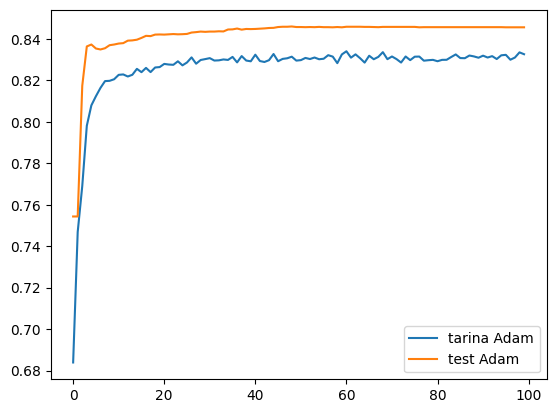

In [5]:
plt.plot(history_Adam.history['accuracy'], label = "tarina Adam")
plt.plot(history_Adam.history['val_accuracy'], label = "test Adam")


plt.legend()
plt.show()

# Zad.
Do poniższego modelu dodaj
```python
model.add(Dropout(0.8))
```
w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)

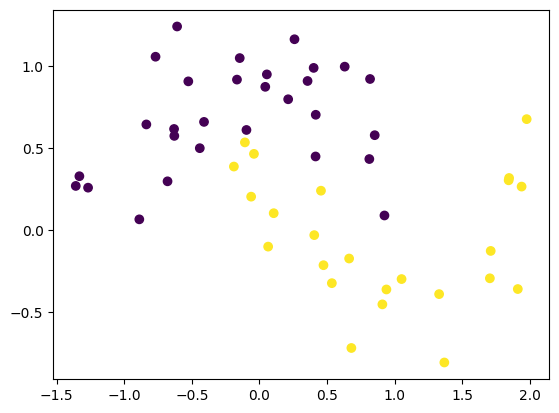

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=5)

n_train=53
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

plt.scatter(X_train[:,0],X_train[:,1], c=y_train)
plt.show()

In [8]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dense(500,activation="sigmoid"))
model.add(Dense(200,activation="sigmoid"))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=10, callbacks=[history_Adam])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1000)              3000      
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                                 
 dense_10 (Dense)            (None, 200)               100200    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2/2 [==============================] - 1s 114ms/step - loss: 0.7167 - accuracy: 0.5094 - val_loss: 0.8043 - val_accuracy: 0.4468
Epoch 2/10
2/2 [========================

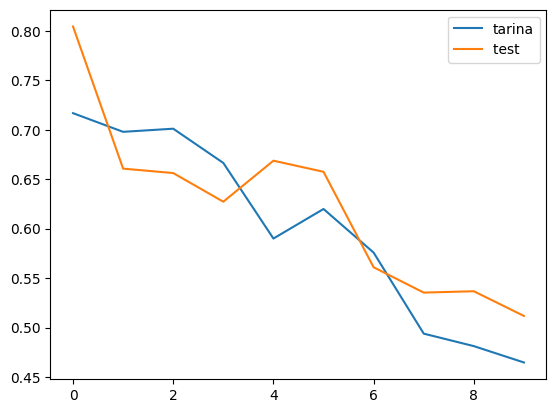

In [9]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")


plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()

3053/9600 [========>.....................] - ETA: 9s

In [ ]:
from keras.callbacks import History


history_Adam = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],)))
model.add(Dropout(0.4))
model.add(Dense(500,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(200,activation="sigmoid"))
model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

lrate = LearningRateScheduler(step_decay)
model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam])


# Zad.
Do poniższego modelu dodaj
 
```python
model.add(BatchNormalization())
model.add(Activation("sigmoid"))
model.add(Dropout(0.3))
```

w każdej warstwie.

Zwizualizuj wyniki:

* porównaj krzywe uczenia
* narysuj granice decyzyjne (dane są w 2D)
* porównaj do powyższego eksperymentu

# Regularyzacja

# Zad.
Do modelu dodaj 
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l1(0.0001)))
```

* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.00001)))
```
* 
```python
model.add(Dense( ... , activity_regularizer=l2(0.0001)))
```

w każdej warstwie.

Zwizualizuj wyniki dla obu modeli.

In [13]:
from keras.callbacks import History
from keras.regularizers import l1


history_Adam_2 = History()
model = Sequential()
model.add(Dense(1000,activation="relu",input_shape=(X_train.shape[1],), activity_regularizer=l1(0.00001)))
model.add(Dense(500,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(200,activation="sigmoid", activity_regularizer=l1(0.00001)))
model.add(Dense(1,activation="sigmoid"))
model.summary()

model.compile(loss="binary_crossentropy",optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=1000, callbacks=[history_Adam_2])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1000)              3000      
_________________________________________________________________
dense_14 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_15 (Dense)             (None, 200)               100200    
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 201       
Total params: 603,901
Trainable params: 603,901
Non-trainable params: 0
_________________________________________________________________
Train on 53 samples, validate on 47 samples
Epoch 1/1000
53/53 [==============================] - 0s 5ms/step - loss: 0.8459 - accuracy: 0.5472 - val_loss: 0.8222 - val_accuracy: 0.4468
Epoch 2/1000
53/53 [==============================] - 0s 585

Epoch 51/1000
53/53 [==============================] - 0s 585us/step - loss: 0.2701 - accuracy: 0.9245 - val_loss: 0.5264 - val_accuracy: 0.8298
Epoch 52/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2667 - accuracy: 0.9434 - val_loss: 0.5145 - val_accuracy: 0.8298
Epoch 53/1000
53/53 [==============================] - 0s 604us/step - loss: 0.2639 - accuracy: 0.9245 - val_loss: 0.5009 - val_accuracy: 0.8298
Epoch 54/1000
53/53 [==============================] - 0s 548us/step - loss: 0.2613 - accuracy: 0.9245 - val_loss: 0.4945 - val_accuracy: 0.8298
Epoch 55/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2601 - accuracy: 0.9245 - val_loss: 0.4905 - val_accuracy: 0.8298
Epoch 56/1000
53/53 [==============================] - 0s 566us/step - loss: 0.2571 - accuracy: 0.9245 - val_loss: 0.4945 - val_accuracy: 0.8298
Epoch 57/1000
53/53 [==============================] - 0s 529us/step - loss: 0.2555 - accuracy: 0.9245 - val_loss: 0.5061 - val_ac

53/53 [==============================] - 0s 604us/step - loss: 0.0918 - accuracy: 1.0000 - val_loss: 0.2400 - val_accuracy: 0.8936
Epoch 164/1000
53/53 [==============================] - 0s 642us/step - loss: 0.0911 - accuracy: 1.0000 - val_loss: 0.2414 - val_accuracy: 0.8936
Epoch 165/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0907 - accuracy: 1.0000 - val_loss: 0.2419 - val_accuracy: 0.8936
Epoch 166/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0902 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.8936
Epoch 167/1000
53/53 [==============================] - 0s 736us/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.8936
Epoch 168/1000
53/53 [==============================] - 0s 963us/step - loss: 0.0898 - accuracy: 1.0000 - val_loss: 0.2426 - val_accuracy: 0.8936
Epoch 169/1000
53/53 [==============================] - 0s 1ms/step - loss: 0.0891 - accuracy: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.

53/53 [==============================] - 0s 473us/step - loss: 0.0655 - accuracy: 1.0000 - val_loss: 0.2904 - val_accuracy: 0.8936
Epoch 276/1000
53/53 [==============================] - 0s 692us/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.2888 - val_accuracy: 0.8936
Epoch 277/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0651 - accuracy: 1.0000 - val_loss: 0.2870 - val_accuracy: 0.8936
Epoch 278/1000
53/53 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 1.00 - 0s 529us/step - loss: 0.0650 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 279/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0648 - accuracy: 1.0000 - val_loss: 0.2863 - val_accuracy: 0.8936
Epoch 280/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0645 - accuracy: 1.0000 - val_loss: 0.2856 - val_accuracy: 0.8936
Epoch 281/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0647 - accuracy: 

53/53 [==============================] - 0s 548us/step - loss: 0.0543 - accuracy: 1.0000 - val_loss: 0.3118 - val_accuracy: 0.8936
Epoch 386/1000
53/53 [==============================] - 0s 314us/step - loss: 0.0536 - accuracy: 1.0000 - val_loss: 0.3097 - val_accuracy: 0.8936
Epoch 387/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0540 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 388/1000
53/53 [==============================] - 0s 825us/step - loss: 0.0544 - accuracy: 1.0000 - val_loss: 0.3088 - val_accuracy: 0.8936
Epoch 389/1000
53/53 [==============================] - 0s 566us/step - loss: 0.0538 - accuracy: 1.0000 - val_loss: 0.3093 - val_accuracy: 0.8936
Epoch 390/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0535 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.8936
Epoch 391/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0534 - accuracy: 1.0000 - val_loss: 0.3105 - val_accuracy: 

53/53 [==============================] - 0s 492us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.8936
Epoch 498/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2959 - val_accuracy: 0.9149
Epoch 499/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0469 - accuracy: 1.0000 - val_loss: 0.2952 - val_accuracy: 0.9149
Epoch 500/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2936 - val_accuracy: 0.9149
Epoch 501/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0467 - accuracy: 1.0000 - val_loss: 0.2918 - val_accuracy: 0.8936
Epoch 502/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0470 - accuracy: 1.0000 - val_loss: 0.2906 - val_accuracy: 0.8936
Epoch 503/1000
53/53 [==============================] - 0s 589us/step - loss: 0.0468 - accuracy: 1.0000 - val_loss: 0.2907 - val_accuracy: 

Epoch 609/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0416 - accuracy: 1.0000 - val_loss: 0.2710 - val_accuracy: 0.9149
Epoch 610/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0417 - accuracy: 1.0000 - val_loss: 0.2703 - val_accuracy: 0.9149
Epoch 611/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0414 - accuracy: 1.0000 - val_loss: 0.2686 - val_accuracy: 0.9149
Epoch 612/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0409 - accuracy: 1.0000 - val_loss: 0.2670 - val_accuracy: 0.9149
Epoch 613/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0413 - accuracy: 1.0000 - val_loss: 0.2667 - val_accuracy: 0.9149
Epoch 614/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2671 - val_accuracy: 0.9149
Epoch 615/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.2669 -

Epoch 665/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0392 - accuracy: 1.0000 - val_loss: 0.2584 - val_accuracy: 0.9149
Epoch 666/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2581 - val_accuracy: 0.9149
Epoch 667/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0391 - accuracy: 1.0000 - val_loss: 0.2575 - val_accuracy: 0.9149
Epoch 668/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2569 - val_accuracy: 0.9149
Epoch 669/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9149
Epoch 670/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0390 - accuracy: 1.0000 - val_loss: 0.2573 - val_accuracy: 0.9149
Epoch 671/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0388 - accuracy: 1.0000 - val_loss: 0.2582 -

Epoch 721/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9149
Epoch 722/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0364 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 723/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9149
Epoch 724/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.2447 - val_accuracy: 0.9149
Epoch 725/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2448 - val_accuracy: 0.9149
Epoch 726/1000
53/53 [==============================] - 0s 623us/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.2450 - val_accuracy: 0.9149
Epoch 727/1000
53/53 [==============================] - 0s 604us/step - loss: 0.0366 - accuracy: 1.0000 - val_loss: 0.2451 -

53/53 [==============================] - 0s 295us/step - loss: 0.0332 - accuracy: 1.0000 - val_loss: 0.2359 - val_accuracy: 0.9149
Epoch 833/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2372 - val_accuracy: 0.9149
Epoch 834/1000
53/53 [==============================] - 0s 776us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2371 - val_accuracy: 0.9149
Epoch 835/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2369 - val_accuracy: 0.9149
Epoch 836/1000
53/53 [==============================] - 0s 246us/step - loss: 0.0331 - accuracy: 1.0000 - val_loss: 0.2373 - val_accuracy: 0.9149
Epoch 837/1000
53/53 [==============================] - 0s 295us/step - loss: 0.0329 - accuracy: 1.0000 - val_loss: 0.2366 - val_accuracy: 0.9149
Epoch 838/1000
53/53 [==============================] - 0s 590us/step - loss: 0.0330 - accuracy: 1.0000 - val_loss: 0.2354 - val_accuracy: 

53/53 [==============================] - 0s 491us/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 0.2244 - val_accuracy: 0.9362
Epoch 945/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2239 - val_accuracy: 0.9149
Epoch 946/1000
53/53 [==============================] - 0s 548us/step - loss: 0.0299 - accuracy: 1.0000 - val_loss: 0.2246 - val_accuracy: 0.9149
Epoch 947/1000
53/53 [==============================] - 0s 491us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2253 - val_accuracy: 0.9149
Epoch 948/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2256 - val_accuracy: 0.9149
Epoch 949/1000
53/53 [==============================] - 0s 529us/step - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.2259 - val_accuracy: 0.9149
Epoch 950/1000
53/53 [==============================] - 0s 510us/step - loss: 0.0297 - accuracy: 1.0000 - val_loss: 0.2250 - val_accuracy: 

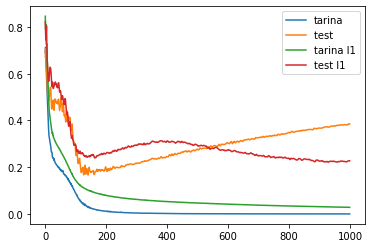

In [14]:
plt.plot(history_Adam.history['loss'], label = "tarina")
plt.plot(history_Adam.history['val_loss'], label = "test ")

# plt.plot(history_Adam_1.history['loss'], label = "tarina dropout")
# plt.plot(history_Adam_1.history['val_loss'], label = "test dropout")

plt.plot(history_Adam_2.history['loss'], label = "tarina l1")
plt.plot(history_Adam_2.history['val_loss'], label = "test l1")

plt.legend()
plt.show()

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_test, y_test, model)
plt.show()